In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv', skiprows=6, skipfooter=9, engine='python')

In [3]:
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [4]:
from pandas.tseries.offsets import MonthEnd

In [5]:
'''adding the date to the time stamp'''

df['Adjustments'] = pd.to_datetime(df['Adjustments'])+MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


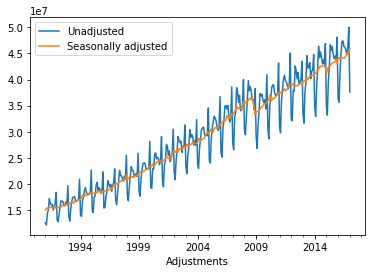

In [6]:
df.plot()

In [7]:
'''splitting the data before and after year 2011'''

split_date = pd.Timestamp('01-01-2011')
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:,['Unadjusted']]

train.head()

,Unadjusted
Adjustments,
1991-01-31,12588862
1991-02-28,12154321
1991-03-31,14337072
1991-04-30,15108570
1991-05-31,17225734


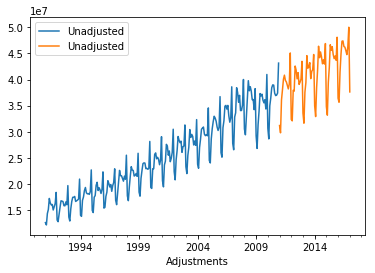

In [8]:
ax=train.plot()
test.plot(ax=ax)

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [21]:
# scaling the univariate variable values

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [22]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

# FULLY CONNECTED

In [12]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as k
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [23]:
'''fully connected neural network'''

k.clear_session()

model = Sequential()

model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [24]:
'''call back'''

early = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [25]:
model.fit(X_train, y_train, epochs=200, batch_size=2, callbacks=[early], verbose=0)

Epoch 00029: early stopping


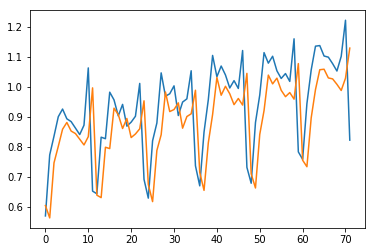

In [26]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

# Recurrent NN

In [27]:
from keras.layers import LSTM

In [28]:
X_train.shape

(239, 1)

In [29]:
# input format if that of shape is shouldbe (batch_size, timestamps, input_dim)

X_train = X_train[:,None]
X_test = X_test[:,None]

In [30]:
'''LSTM model for forecasting'''

k.clear_session()

model = Sequential()
model.add(LSTM(6, input_dim=1))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(6, input_shape=(None, 1))`
  


In [32]:
'''Training the LSTM'''

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0, callbacks=[early])

Epoch 00010: early stopping


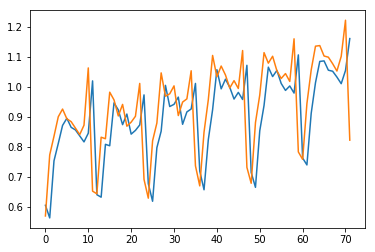

In [34]:
y_pred = model.predict(X_test)
plt.plot(y_pred)
plt.plot(y_test)

# WINDOW DNN

In [35]:
train_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)

In [36]:
'''adding previous 12 month data for the input arrays'''

for s in range(1,13):
    train_df['shift{}'.format(s)] = train_df['Scaled'].shift(s)
    test_df['shift{}'.format(s)] = test_df['Scaled'].shift(s)
    
# for providing as wiondows

In [37]:
train_df.head(13)

,Scaled,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [38]:
X_train = train_df.dropna().drop('Scaled', axis=1)
y_train = train_df.dropna()[['Scaled']]

X_test = test_df.dropna().drop('Scaled', axis=1)
y_test = test_df.dropna()[['Scaled']]

In [39]:
X_train = X_train.values
X_test = X_test.values

y_train = y_train.values
y_test = y_test.values

In [40]:
'''window DNN'''
'''for better feature learning and efficient forecasting'''


k.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train, y_train, epochs=200, verbose=0, batch_size=1,callbacks=[early])

Epoch 00008: early stopping


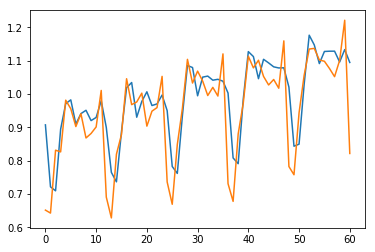

In [42]:
y_pred = model.predict(X_test)
plt.plot(y_pred)
plt.plot(y_test)

# Window LSTM 

In [44]:
X_train = X_train.reshape(X_train.shape[0], 1,12)
X_test = X_test.reshape(X_test.shape[0], 1,12)

In [46]:
'''LSTM with window'''

k.clear_session()

model = Sequential()
model.add(LSTM(6, input_dim=12))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(6, input_shape=(None, 12))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [47]:
'''LSTM model training'''

model.fit(X_train, y_train, epochs=100, callbacks=[early], batch_size=1, verbose=0)

Epoch 00025: early stopping


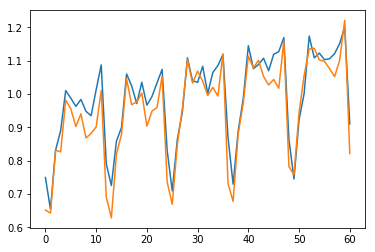

In [48]:
y_pred= model.predict(X_test)
plt.plot(y_pred)
plt.plot(y_test)

In [48]:
'''Rehsaping the input vector into single vector to reduce the number of parameters to learn '''

In [43]:
X_train = X_train.reshape(X_train.shape[0], 12, 1)
X_test = X_test.reshape(X_test.shape[0], 12, 1)

In [57]:
'''LSTM window (less parameters to learn)'''

k.clear_session()

model = Sequential()
model.add(LSTM(6, input_shape=(12,1)))
model.add(Dense(1)),

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


Epoch 1/600
228/228 [==============================] - 0s 696us/step - loss: 0.0070
Epoch 2/600
228/228 [==============================] - 0s 506us/step - loss: 0.0066
Epoch 3/600
228/228 [==============================] - 0s 530us/step - loss: 0.0059
Epoch 4/600
228/228 [==============================] - 0s 527us/step - loss: 0.0056
Epoch 5/600
228/228 [==============================] - 0s 547us/step - loss: 0.0056
Epoch 6/600
228/228 [==============================] - 0s 593us/step - loss: 0.0056
Epoch 7/600
228/228 [==============================] - 0s 675us/step - loss: 0.0056
Epoch 8/600
228/228 [==============================] - 0s 552us/step - loss: 0.0055
Epoch 9/600
228/228 [==============================] - 0s 520us/step - loss: 0.0055
Epoch 10/600
228/228 [==============================] - 0s 529us/step - loss: 0.0055
Epoch 11/600
228/228 [==============================] - 0s 577us/step - loss: 0.0055
Epoch 12/600
228/228 [==============================] - 0s 571us/step - lo

228/228 [==============================] - 0s 613us/step - loss: 0.0050
Epoch 98/600
228/228 [==============================] - 0s 399us/step - loss: 0.0049
Epoch 99/600
228/228 [==============================] - 0s 477us/step - loss: 0.0049
Epoch 100/600
228/228 [==============================] - 0s 579us/step - loss: 0.0049
Epoch 101/600
228/228 [==============================] - 0s 420us/step - loss: 0.0049
Epoch 102/600
228/228 [==============================] - 0s 642us/step - loss: 0.0049
Epoch 103/600
228/228 [==============================] - 0s 437us/step - loss: 0.0049
Epoch 104/600
228/228 [==============================] - 0s 382us/step - loss: 0.0049
Epoch 105/600
228/228 [==============================] - 0s 524us/step - loss: 0.0049
Epoch 106/600
228/228 [==============================] - 0s 464us/step - loss: 0.0049
Epoch 107/600
228/228 [==============================] - 0s 359us/step - loss: 0.0049
Epoch 108/600
228/228 [==============================] - 0s 493us/step

228/228 [==============================] - 0s 726us/step - loss: 0.0030
Epoch 287/600
228/228 [==============================] - 0s 906us/step - loss: 0.0030
Epoch 288/600
228/228 [==============================] - 0s 687us/step - loss: 0.0030
Epoch 289/600
228/228 [==============================] - 0s 505us/step - loss: 0.0030
Epoch 290/600
228/228 [==============================] - 0s 550us/step - loss: 0.0030
Epoch 291/600
228/228 [==============================] - 0s 464us/step - loss: 0.0030
Epoch 292/600
228/228 [==============================] - 0s 508us/step - loss: 0.0030
Epoch 293/600
228/228 [==============================] - 0s 496us/step - loss: 0.0029
Epoch 294/600
228/228 [==============================] - 0s 460us/step - loss: 0.0029
Epoch 295/600
228/228 [==============================] - 0s 451us/step - loss: 0.0029
Epoch 296/600
228/228 [==============================] - 0s 516us/step - loss: 0.0029
Epoch 297/600
228/228 [==============================] - 0s 446us/st

228/228 [==============================] - 0s 465us/step - loss: 9.0626e-04
Epoch 473/600
228/228 [==============================] - 0s 369us/step - loss: 9.1319e-04
Epoch 474/600
228/228 [==============================] - 0s 424us/step - loss: 9.2786e-04
Epoch 475/600
228/228 [==============================] - 0s 424us/step - loss: 9.0475e-04
Epoch 476/600
228/228 [==============================] - 0s 394us/step - loss: 9.0481e-04
Epoch 477/600
228/228 [==============================] - 0s 438us/step - loss: 9.3182e-04
Epoch 478/600
228/228 [==============================] - 0s 417us/step - loss: 9.2837e-04
Epoch 479/600
228/228 [==============================] - 0s 442us/step - loss: 9.0357e-04
Epoch 480/600
228/228 [==============================] - 0s 435us/step - loss: 9.1428e-04
Epoch 481/600
228/228 [==============================] - 0s 396us/step - loss: 9.5595e-04
Epoch 482/600
228/228 [==============================] - 0s 449us/step - loss: 8.8797e-04
Epoch 483/600
228/228 [=

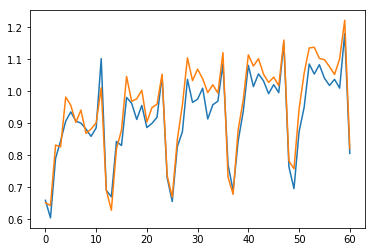

In [59]:
'''Need to train for higher epochs as we compromised on the number of parameters to learn'''

model.fit(X_train, y_train, epochs=600, batch_size=32)

y_pred= model.predict(X_test)
plt.plot(y_pred)
plt.plot(y_test)